In [1]:
# import system libs
import os
import time
# import data handling tools
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Activation, GlobalAveragePooling2D
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

2024-02-15 13:33:50.282516: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-15 13:33:50.282607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-15 13:33:50.412980: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Class for Loading and Splitting Datasets

In [2]:
class EyeDiseaseDataset:
    def __init__(self, dataDir):
        self.data_dir = dataDir
   
    def dataPaths(self):
        filepaths = []
        labels = []
        folds = os.listdir(self.data_dir)
        for fold in folds:
            foldPath = os.path.join(self.data_dir, fold)
            filelist = os.listdir(foldPath)
            for file in filelist:
                fpath = os.path.join(foldPath, file)
                filepaths.append(fpath)
                labels.append(fold)
        return filepaths, labels
  
    def dataFrame(self, files, labels):

        Fseries = pd.Series(files, name='filepaths')
        Lseries = pd.Series(labels, name='labels')
        return pd.concat([Fseries, Lseries], axis=1)
   
    def split_(self):
        files, labels = self.dataPaths()
        df = self.dataFrame(files, labels)
        strat = df['labels']
        trainData, dummyData = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=strat)
        strat = dummyData['labels']
        validData, testData = train_test_split(dummyData, train_size=0.5, shuffle=True, random_state=42, stratify=strat)
        return trainData, validData, testData

In [3]:
dataDir='/kaggle/input/eye-diseases-classification/dataset'

In [4]:
dataSplit = EyeDiseaseDataset(dataDir)
train_data, valid_data, test_data = dataSplit.split_()

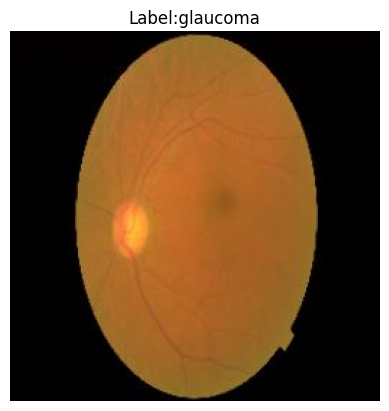

In [5]:
def display_random_image(df):
    random_row = df.sample(1).iloc[0]
    filepath = random_row['filepaths']
    label = random_row['labels']
    
    img = Image.open(filepath)
    plt.imshow(img)
    plt.title(f'Label:{label}')
    plt.axis('off')
    plt.show()

display_random_image(train_data)

## Function for Data Augmentation

In [6]:
def augment_data( train_df, valid_df, test_df, batch_size=16):

    img_size = (256,256)
    channels = 3
    color = 'rgb'
    

    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
              rotation_range=30,
              horizontal_flip=True,
              vertical_flip=True,
              brightness_range=[0.5, 1.5])
          
    valid_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
          
    train_generator = train_datagen.flow_from_dataframe(
              train_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
   
    print("Shape of augmented training images:", train_generator.image_shape)
          
    valid_generator = valid_test_datagen.flow_from_dataframe(
              valid_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=True,
              class_mode='categorical'
          )
         
    print("Shape of validation images:", valid_generator.image_shape)
          
    test_generator = valid_test_datagen.flow_from_dataframe(
              test_df,
              x_col='filepaths',
              y_col='labels',
              target_size=img_size,
              color_mode=color,
              batch_size=batch_size,
              shuffle=False,
              class_mode='categorical'
          )
          
    print("Shape of test images:", test_generator.image_shape)
          
    return train_generator, valid_generator, test_generator

In [7]:
train_augmented, valid_augmented, test_augmented = augment_data(train_data, valid_data, test_data)

Found 3373 validated image filenames belonging to 4 classes.
Shape of augmented training images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of validation images: (256, 256, 3)
Found 422 validated image filenames belonging to 4 classes.
Shape of test images: (256, 256, 3)


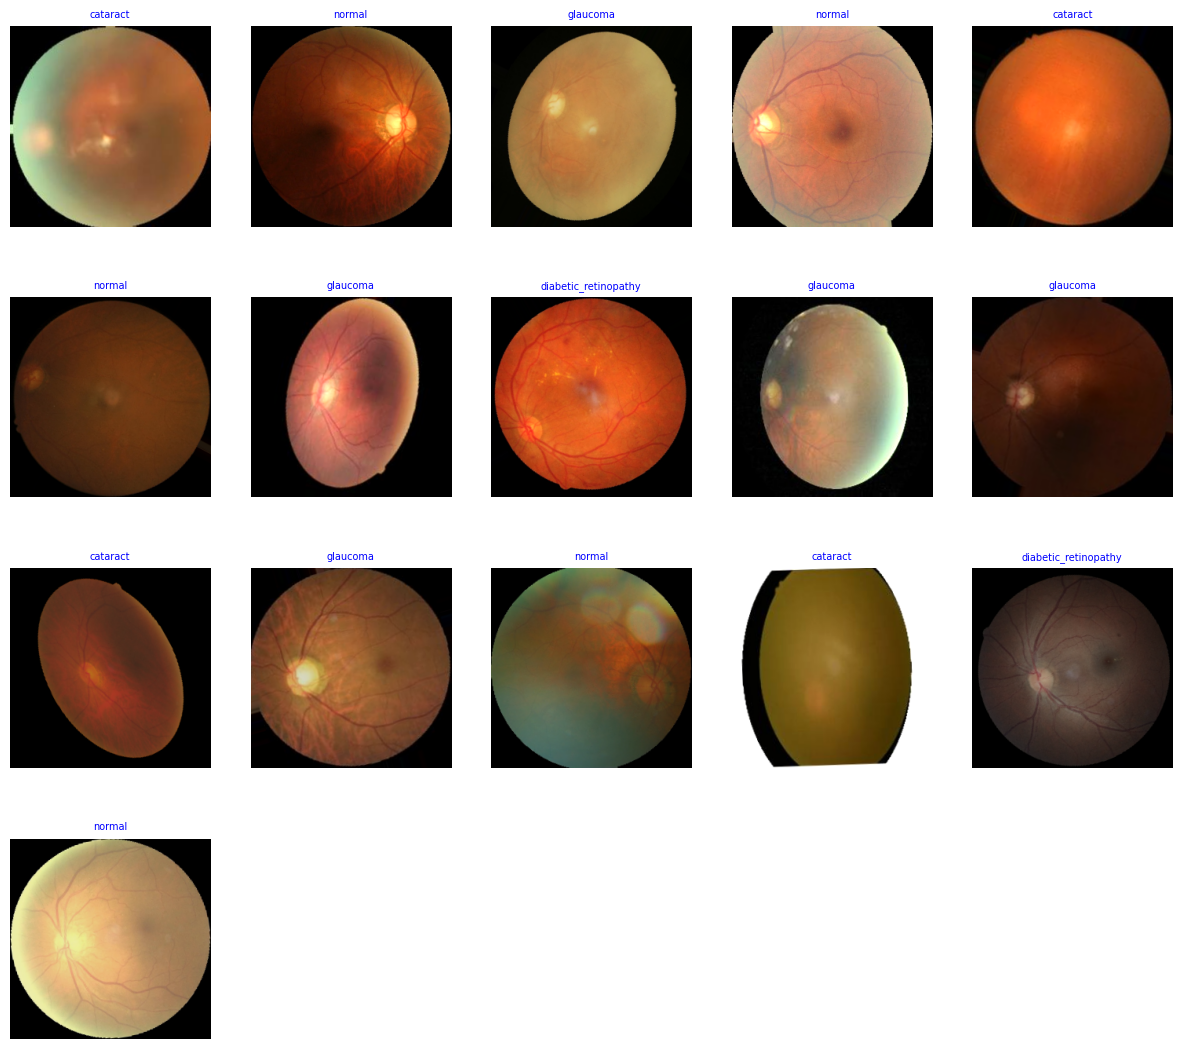

In [8]:
def show_images(gen):
      
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator
    length = len(labels)       
    sample = min(length, 20)   
    plt.figure(figsize= (15, 17))
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255      
        plt.imshow(image)
        index = np.argmax(labels[i])  
        class_name = classes[index]  
        plt.title(class_name, color= 'blue', fontsize= 7 )
        plt.axis('off')
    plt.show()
show_images(train_augmented)

## Download and compile the model

In [15]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras import regularizers

classes = len(list(train_augmented.class_indices.keys()))

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

for layer in base_model.layers:
    layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu' , kernel_regularizer = regularizers.l2(0.01))(x)

predictions = Dense(classes, activation='softmax', kernel_regularizer = regularizers.l2(0.01))(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

## Fit the model

In [16]:
history = model.fit(
    train_augmented,
    epochs=15, 
    validation_data=valid_augmented,
    )

Epoch 1/15


2024-02-15 14:11:59.469994: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


211/211 [==============================] - 86s 356ms/step - loss: 2.3411 - accuracy: 0.7415 - val_loss: 0.8908 - val_accuracy: 0.8104
Epoch 2/15
211/211 [==============================] - 73s 345ms/step - loss: 0.8038 - accuracy: 0.7824 - val_loss: 0.7640 - val_accuracy: 0.7938
Epoch 3/15
211/211 [==============================] - 72s 342ms/step - loss: 0.7188 - accuracy: 0.7821 - val_loss: 0.8021 - val_accuracy: 0.7654
Epoch 4/15
211/211 [==============================] - 72s 340ms/step - loss: 0.6922 - accuracy: 0.7922 - val_loss: 0.7604 - val_accuracy: 0.7773
Epoch 5/15
211/211 [==============================] - 71s 335ms/step - loss: 0.6968 - accuracy: 0.7940 - val_loss: 0.7130 - val_accuracy: 0.7773
Epoch 6/15
211/211 [==============================] - 71s 335ms/step - loss: 0.6758 - accuracy: 0.7957 - val_loss: 0.6705 - val_accuracy: 0.8033
Epoch 7/15
211/211 [==============================] - 71s 338ms/step - loss: 0.6675 - accuracy: 0.8005 - val_loss: 0.7643 - val_accuracy: 0.7

## Plot the Accuracy and Loss

Training Accuracy: 0.8096649646759033
Validation Accuracy: 0.8199052214622498


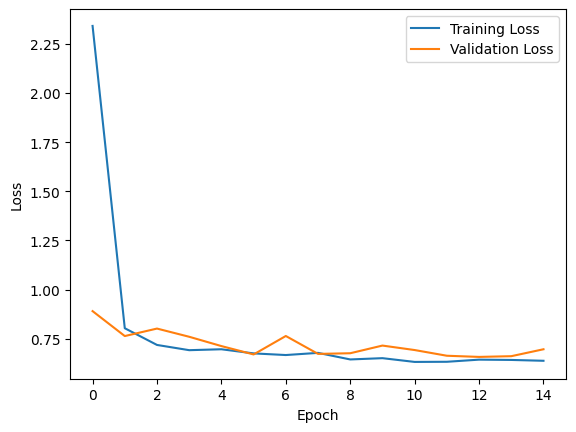

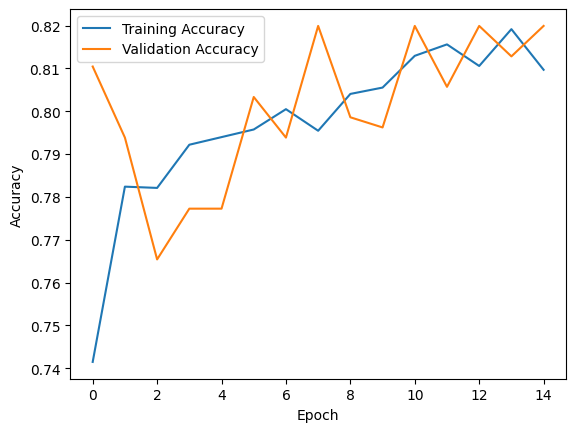

In [17]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
print("Training Accuracy:", train_accuracy[-1])
print("Validation Accuracy:", val_accuracy[-1])
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Display the Actual and Predicted images

1/1 [==============================] - 2s 2s/step


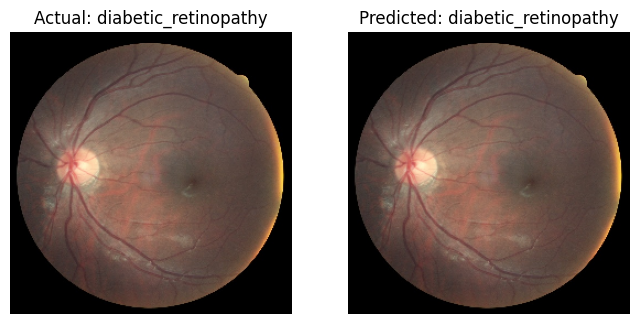

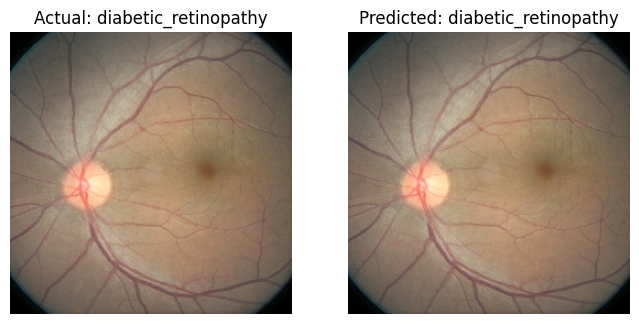

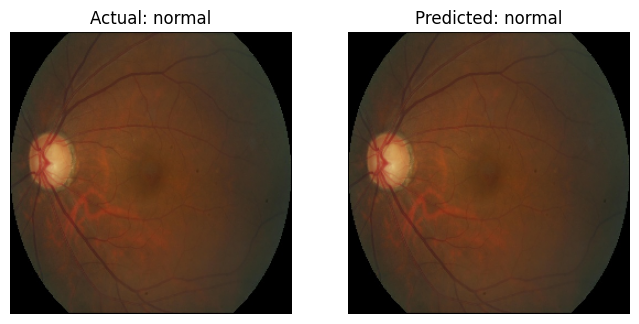

In [18]:
def plot_actual_vs_predicted(model, test_data, num_samples=3):
    
    # Get a batch of test data
    test_images, test_labels = next(iter(test_data))

    predictions = model.predict(test_images)

    class_labels = list(train_augmented.class_indices.keys())

    sample_indices = np.random.choice(range(len(test_images)), num_samples, replace=False)
      # Plot the images with actual and predicted labels
    for i in sample_indices:
        actual_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[np.argmax(predictions[i])]
        plt.figure(figsize=(8, 4))
        # Actual Image
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Actual: {actual_label}')
        plt.axis('off')
        # Predicted Image
        plt.subplot(1, 2, 2)
        plt.imshow(test_images[i].astype(np.uint8))  
        plt.title(f'Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
plot_actual_vs_predicted(model, test_augmented)